<a href="https://colab.research.google.com/github/nguyen-nhat-mai/object_detection/blob/main/Rotate_img_yolo.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Rotating image & box in YOLO format

In [35]:
import cv2
import pandas as pd
import numpy as np
import os
from os import listdir
from os.path import isfile, join
from matplotlib import pyplot as plt
from matplotlib.patches import Rectangle
from decimal import Decimal
import random

## Define function to rotate image & box in YOLO format

In [19]:
# Convert box coordinate from yolo to cv
def yoloFormattocv(x1, y1, x2, y2, H, W):
    bbox_width = x2 * W
    bbox_height = y2 * H
    center_x = x1 * W
    center_y = y1 * H
    cv = []
    cv.append(center_x - (bbox_width / 2))
    cv.append(center_y - (bbox_height / 2))
    cv.append(center_x + (bbox_width / 2))
    cv.append(center_y + (bbox_height / 2))
    return [int(v) for v in cv]

In [20]:
# Plot yolo box
box_color = {0:'blue',1:'orange',2:'green',3:'purple',4:'brown',5:'pink',
             6:'gray',7:'olive',8:'cyan',9:'gold',10:'turquoise',11:'navy',12:'yellow',13:'red'}
box_name = {0:'RazorBlade',1:'SafetyPin',2:'PaperClip',3:'Pen',4:'ThinNail',5:'Screw',
            6:'HandGun',7:'VgaConnector',8:'Knife',9:'MultiPurposeKnife',10:'Key',11:'Plier',12:'Shuriken',13:'Scissor'}
def plot_box(box_yolo_coordinates, height, width):
  ''' Input: list of boxes
      Output: plot of boxes'''
  for row in box_yolo_coordinates:
    bbox = row.strip('\n').split(' ')
    [x1,y1,x2,y2] = yoloFormattocv(Decimal(bbox[1]),Decimal(bbox[2]),Decimal(bbox[3]),Decimal(bbox[4]),height, width)
    plt.gca().add_patch(Rectangle((x1,y1),x2-x1,y2-y1, edgecolor=box_color[int(bbox[0])], facecolor='none', lw=1))
    plt.annotate(box_name[int(bbox[0])], ((x2+x1)/2, (y2+y1)/2), 
                 color=box_color[int(bbox[0])], weight='bold', fontsize=10, ha='center', va='center') # label at the center of the box

In [21]:
def cvFormattoYolo(corner, H, W):
    ''' Input: list of coordinates in cv format ['label','x1','y1','x2','y2']
        Output: list of coordinates in yolo format 'label x_center y_center box_width box_height' '''
    bbox_W = corner[3] - corner[1]
    bbox_H = corner[4] - corner[2]

    center_bbox_x = (corner[1] + corner[3]) / 2
    center_bbox_y = (corner[2] + corner[4]) / 2

    return corner[0]+' '+str(round(center_bbox_x / W, 6))+' '+str(round(center_bbox_y / H, 6))+' '+str(round(bbox_W / W, 6))+' '+str(round(bbox_H / H, 6))

In [28]:
class yoloRotatebbox:
    def __init__(self, img_folder_path, box_folder_path,filename, image_ext, angle):
        assert os.path.isfile(img_folder_path + "/" + filename + image_ext)
        assert os.path.isfile(box_folder_path + "/" + filename + '.txt')

        self.img_folder_path = img_folder_path
        self.box_folder_path = box_folder_path
        self.filename = filename
        self.image_ext = image_ext
        self.angle = angle

        # Read image using cv2
        self.image = cv2.imread(self.img_folder_path + "/" + self.filename + self.image_ext, 1)

        # create a 2D-rotation matrix
        rotation_angle = self.angle * np.pi / 180
        self.rot_matrix = np.array(
            [[np.cos(rotation_angle), -np.sin(rotation_angle)], [np.sin(rotation_angle), np.cos(rotation_angle)]])
        
    def rotate_image(self):
        """
        Rotates an image (angle in degrees) and expands image to avoid cropping
        """
        height, width = self.image.shape[:2]  # image shape has 3 dimensions
        image_center = (width / 2,
                        height / 2)  # getRotationMatrix2D needs coordinates in reverse order (width, height) compared to shape

        rotation_mat = cv2.getRotationMatrix2D(image_center, self.angle, 1.)

        # rotation calculates the cos and sin, taking absolutes of those.
        abs_cos = abs(rotation_mat[0, 0])
        abs_sin = abs(rotation_mat[0, 1])

        # find the new width and height bounds
        bound_w = int(height * abs_sin + width * abs_cos)
        bound_h = int(height * abs_cos + width * abs_sin)

        # subtract old image center (bringing image back to origin) and adding the new image center coordinates
        rotation_mat[0, 2] += bound_w / 2 - image_center[0]
        rotation_mat[1, 2] += bound_h / 2 - image_center[1]

        # rotate image with the new bounds and translated rotation matrix
        rotated_mat = cv2.warpAffine(self.image, rotation_mat, (bound_w, bound_h))
        return rotated_mat

    def rotateYolobbox(self):

        new_height, new_width = self.rotate_image().shape[:2]

        f = open(self.box_folder_path + "/" + self.filename + '.txt', 'r')

        f1 = f.readlines()

        yolo_bbox = []

        H, W = self.image.shape[:2]

        for x in f1:
            bbox = x.strip('\n').split(' ')
            if len(bbox) > 1:
                (center_x, center_y, bbox_width, bbox_height) = yoloFormattocv(float(bbox[1]), float(bbox[2]),
                                                                               float(bbox[3]), float(bbox[4]), H, W)
                
                # shift the origin to the center of the image.
                upper_left_corner_shift = (center_x - W / 2, -H / 2 + center_y)
                upper_right_corner_shift = (bbox_width - W / 2, -H / 2 + center_y)
                lower_left_corner_shift = (center_x - W / 2, -H / 2 + bbox_height)
                lower_right_corner_shift = (bbox_width - W / 2, -H / 2 + bbox_height)

                new_lower_right_corner = [-1, -1]
                new_upper_left_corner = []

                for i in (upper_left_corner_shift, upper_right_corner_shift, lower_left_corner_shift,
                          lower_right_corner_shift):
                    new_coords = np.matmul(self.rot_matrix, np.array((i[0], -i[1])))
                    x_prime, y_prime = new_width / 2 + new_coords[0], new_height / 2 - new_coords[1]
                    if new_lower_right_corner[0] < x_prime:
                        new_lower_right_corner[0] = x_prime
                    if new_lower_right_corner[1] < y_prime:
                        new_lower_right_corner[1] = y_prime

                    if len(new_upper_left_corner) > 0:
                        if new_upper_left_corner[0] > x_prime:
                            new_upper_left_corner[0] = x_prime
                        if new_upper_left_corner[1] > y_prime:
                            new_upper_left_corner[1] = y_prime
                    else:
                        new_upper_left_corner.append(x_prime)
                        new_upper_left_corner.append(y_prime)
                #             print(x_prime, y_prime)

                voc_bbox = [bbox[0], new_upper_left_corner[0], new_upper_left_corner[1],
                                 new_lower_right_corner[0], new_lower_right_corner[1]]
                yolo_bbox.append(cvFormattoYolo(voc_bbox,H,W))

        return yolo_bbox

## Test out the function

['8 0.498665 0.497997 0.966622 0.176235']

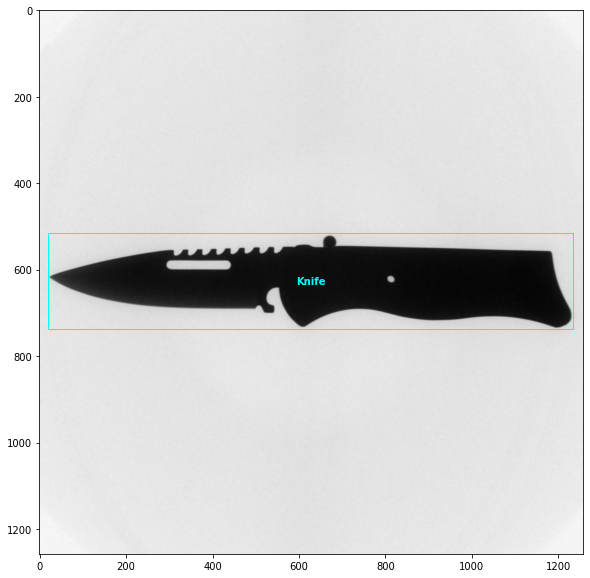

In [25]:
# Plot original image and its box
img_folder_path = "Test_image"
image_name = 'B0076_0001'
image_ext = '.png'
image = cv2.imread(img_folder_path + "/" + image_name + image_ext)
plt.rcParams["figure.figsize"] = (20,10)
plt.imshow(image)

box_folder_path = "Test_annotation"
height, width,_ = image.shape
f = open(box_folder_path+"/"+image_name + '.txt', 'r')
box_list = f.readlines()
plot_box(box_list, height, width)
box_list

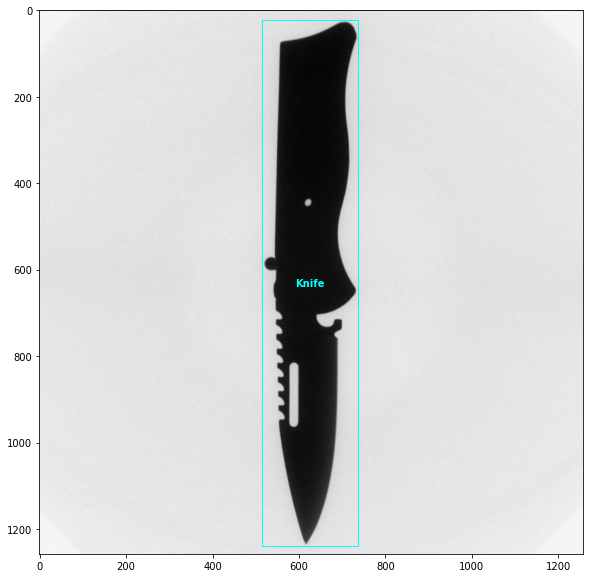

In [29]:
# Rotate 90 degree
im = yoloRotatebbox(img_folder_path, box_folder_path, image_name, image_ext, 90)
image_90 = im.rotate_image()
bbox_90 = im.rotateYolobbox()

plt.rcParams["figure.figsize"] = (20,10)
plt.imshow(image_90)
plot_box(bbox_90, height, width)

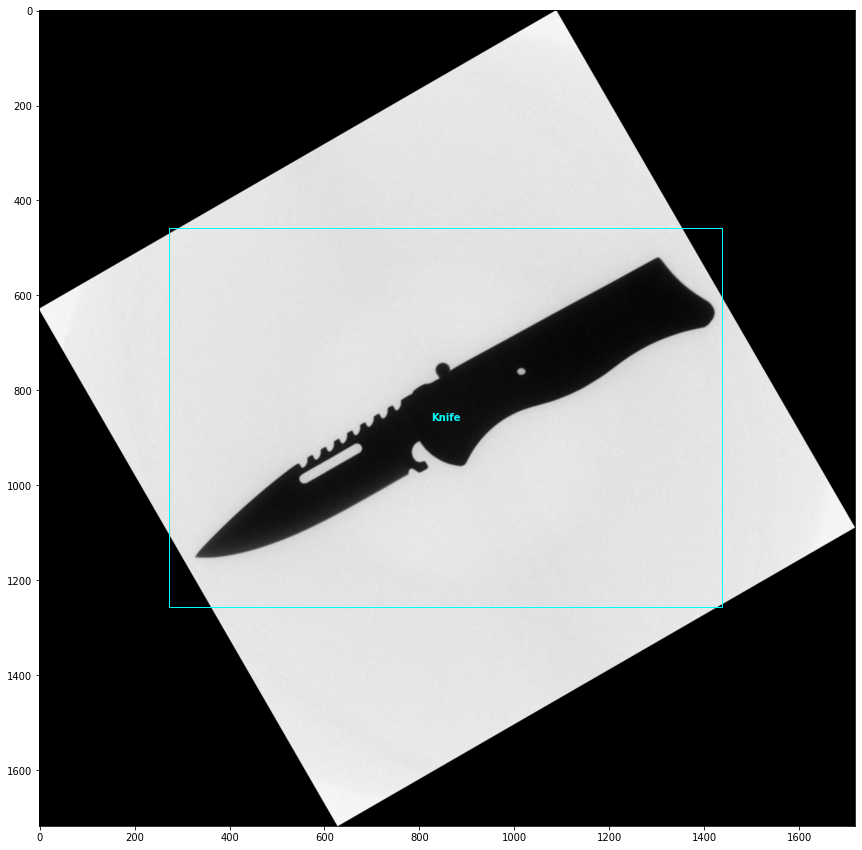

In [30]:
# Rotate 30 degree
im = yoloRotatebbox(img_folder_path, box_folder_path, image_name, image_ext, 30)
image_30 = im.rotate_image()
bbox_30 = im.rotateYolobbox()

plt.rcParams["figure.figsize"] = (30,15)
plt.imshow(image_30)
plot_box(bbox_30, height, width)

## Generate rotated images from existing images

['8 0.497615 0.50159 0.176471 0.966614']


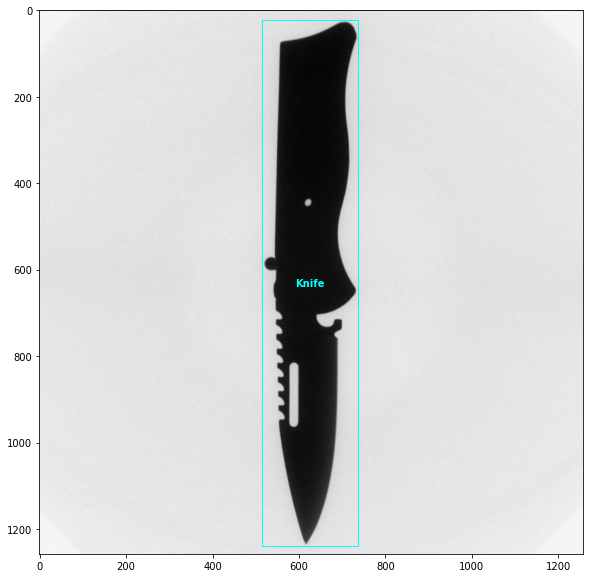

In [37]:
# Rotate 90 degree
im = yoloRotatebbox(img_folder_path, box_folder_path, image_name, image_ext, 90)
image_90 = im.rotate_image()
bbox_90 = im.rotateYolobbox()
print(bbox_90)

In [40]:
cv2.imwrite("check"+"/"+'rotated_'+image_name+'_' + str(90) + '.png', image_90)

True

In [ ]:
file_name = "check"+"/"+'rotated_'+image_name+'_' + str(90) + '.txt'
if os.path.exists(file_name):
    os.remove(file_name)

for i in bbox_90:
    with open(file_name, 'a') as fout:
        fout.writelines(' '.join(map(str, cvFormattoYolo(i, im.rotate_image().shape[0], im.rotate_image().shape[1]))) + '\n')

In [ ]:
def generate_rotated_image(image_folder_path, annotation_folder_path, save_img_pth, save_annotation_path, from_degree, to_degree):
  # Extract image & annotation name
  image_list = [i for i in listdir(image_folder_path) if isfile(join(image_folder_path, i))]

  # Rotate image & box in Yolo format
  for img in image_list:
    name = img[0].split(".")[0]
    degree = random.randint(from_degree,to_degree)
    rotate = yoloRotatebbox(image_folder_path, annotation_folder_path, name, "png", degree)
    rotate_img = rotate.rotate_image()
    rotate_box = rotate.rotateYolobbox()

  # Save image and box into destination folders
  